# Train Model on first Iteration using a dataset of original authentic drug images and counterfeit drug images created from GenAI and Test on counterfeit drug images generated from Albumentation + OCR and GenAI

## Counting Files Script To Verify Class balance in datasets

In [2]:
from google.colab import drive
import os

# Mount your Google Drive
drive.mount('/content/drive')

# Path to your dataset folder inside Drive
folder_path = "/content/drive/MyDrive/Colab_Notebooks/Counterfeit_med_dataset_trainOnAlbu_testOnGenAI/test/counterfeit"

# Define valid image extensions
image_extensions = ('.png', '.jpg', '.jpeg')

# List and count image files
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(image_extensions)]

print(f"Number of image files in '{folder_path}': {len(image_files)}")

Mounted at /content/drive
Number of image files in '/content/drive/MyDrive/Colab_Notebooks/Counterfeit_med_dataset_trainOnAlbu_testOnGenAI/test/counterfeit': 192


## Device Setup

In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
from google.colab import drive
drive.mount('/content/drive')

True
NVIDIA L4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

## Transform setup

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Augmentation for Training

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

## Load first dataset via ImageFolder for first iteration

In [ ]:
# Paths
train_path = "/content/drive/MyDrive/Colab_Notebooks/Counterfeit_med_dataset_trainOnGenAI_testOnGenAI&Albu/train"
val_path = "/content/drive/MyDrive/Colab_Notebooks/Counterfeit_med_dataset_trainOnGenAI_testOnGenAI&Albu/valid"
test_path = "/content/drive/MyDrive/Colab_Notebooks/Counterfeit_med_dataset_trainOnGenAI_testOnGenAI&Albu/test"


# Datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=val_test_transform)

# Class distribution insight
print("Class distribution in training set:")
print(Counter([label for _, label in train_dataset]))

class_names = train_dataset.classes  # ['authentic', 'counterfeit', 'not_medication']



train_loader = DataLoader(train_dataset, batch_size=128,num_workers=4, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=4, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128,num_workers=4, pin_memory=True, shuffle=False)


Class distribution in training set:
Counter({2: 3500, 0: 2886, 1: 762})


## Load & Customize ResNet18, DenseNet, VGG, Xception

In [7]:
import torchvision.models as models
import torch.nn as nn

def get_model(name):
    if name == "resnet18":
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 3)

    elif name == "resnet50":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 3)

    elif name == "resnet101":
        model = models.resnet101(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 3)

    else:
        raise ValueError(f"Unknown model name: {name}")

    return model.to(device)

## Defining Functions to Train Model and Evaluate

In [8]:
def train_model(model, train_loader, val_loader, epochs=20, patience=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        val_acc = evaluate_model(model, val_loader)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Val Accuracy: {val_acc:.2f}%")

        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")  # Save best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

## Training with ResNet 18

In [ ]:
# model = get_model("resnet101")       # ResNet101
# model = get_model("resnet50")  # ResNet50
model = get_model("resnet18")    # ResNet18

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


## Defining Method for evaluating performance

In [9]:

def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total

# Detailed metrics
def evaluate_model_metrics(model, loader, class_names):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


## First Training

In [ ]:
train_model(model, train_loader, val_loader, epochs=20, patience=3)

Epoch [1/20] - Loss: 0.1401 - Val Accuracy: 93.21%
Epoch [2/20] - Loss: 0.0572 - Val Accuracy: 95.95%
Epoch [3/20] - Loss: 0.0384 - Val Accuracy: 94.75%
Epoch [4/20] - Loss: 0.0387 - Val Accuracy: 96.29%
Epoch [5/20] - Loss: 0.0331 - Val Accuracy: 97.32%
Epoch [6/20] - Loss: 0.0234 - Val Accuracy: 89.04%
Epoch [7/20] - Loss: 0.0230 - Val Accuracy: 96.69%
Epoch [8/20] - Loss: 0.0143 - Val Accuracy: 92.07%
Early stopping triggered at epoch 8


## Evaluation Metrics for Testing

In [ ]:
test_acc = evaluate_model(model, test_loader)
print(f" Final Test Accuracy: {test_acc:.2f}%")

 Final Test Accuracy: 97.18%


# plotting to see overfitting or underfitting by plotting confusion matrix and evaluation metics

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

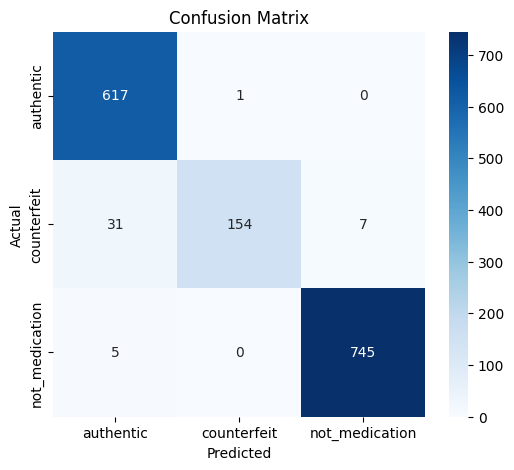

📋 Classification Report:
                precision    recall  f1-score   support

     authentic     0.9449    0.9984    0.9709       618
   counterfeit     0.9935    0.8021    0.8876       192
not_medication     0.9907    0.9933    0.9920       750

      accuracy                         0.9718      1560
     macro avg     0.9764    0.9313    0.9502      1560
  weighted avg     0.9729    0.9718    0.9708      1560



In [ ]:
evaluate_model_metrics(model, test_loader,class_names)

# Train model on second Iteration using a dataset of original authentic drug images and counterfeit drug images created from albumentation & OCR and Test on counterfeit drug images generated from Gen AI Only

## Loading Second Dataset

In [ ]:
# Paths
train_path = "/content/drive/MyDrive/Colab_Notebooks/Counterfeit_med_dataset_trainOnAlbu_testOnGenAI/train"
val_path = "/content/drive/MyDrive/Colab_Notebooks/Counterfeit_med_dataset_trainOnAlbu_testOnGenAI/valid"
test_path = "/content/drive/MyDrive/Colab_Notebooks/Counterfeit_med_dataset_trainOnAlbu_testOnGenAI/test"


# Datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=val_test_transform)

# Class distribution insight
print("Class distribution in training set:")
print(Counter([label for _, label in train_dataset]))

class_names = train_dataset.classes  # ['authentic', 'counterfeit', 'not_medication']



train_loader = DataLoader(train_dataset, batch_size=128,num_workers=4, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=4, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128,num_workers=4, pin_memory=True, shuffle=False)


Class distribution in training set:
Counter({2: 3500, 0: 2886, 1: 1016})


## Training With Resnet 18 Again

---



In [ ]:
train_model(model, train_loader, val_loader, epochs=20, patience=3)

Epoch [1/20] - Loss: 0.0577 - Val Accuracy: 98.86%
Epoch [2/20] - Loss: 0.0281 - Val Accuracy: 99.03%
Epoch [3/20] - Loss: 0.0180 - Val Accuracy: 98.63%
Epoch [4/20] - Loss: 0.0263 - Val Accuracy: 98.63%
Epoch [5/20] - Loss: 0.0307 - Val Accuracy: 98.63%
Early stopping triggered at epoch 5


## Testing Overall Accuracy

In [ ]:
test_acc = evaluate_model(model, test_loader)
print(f" Final Test Accuracy: {test_acc:.2f}%")

 Final Test Accuracy: 90.06%


## Plotting Overall Metrics

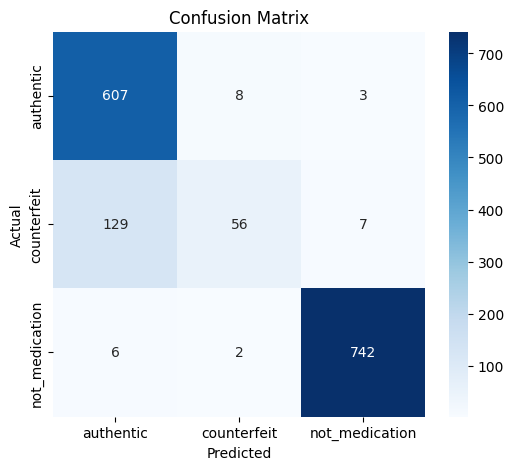

📋 Classification Report:
                precision    recall  f1-score   support

     authentic     0.8181    0.9822    0.8926       618
   counterfeit     0.8485    0.2917    0.4341       192
not_medication     0.9867    0.9893    0.9880       750

      accuracy                         0.9006      1560
     macro avg     0.8844    0.7544    0.7716      1560
  weighted avg     0.9029    0.9006    0.8821      1560



In [ ]:
evaluate_model_metrics(model, test_loader,class_names)

# Train model on third Iteration using a super dataset combining sources 3 sources of authentic drug images Dataset A + Dataset B + Dataset C and generating counterfeit images from Dataset B and Dataset C

## Loading third final Dataset

In [ ]:
# Paths
train_path = "/content/drive/MyDrive/Colab_Notebooks/counterfeit_drug_super_dataset/train"
val_path = "/content/drive/MyDrive/Colab_Notebooks/counterfeit_drug_super_dataset/valid"
test_path = "/content/drive/MyDrive/Colab_Notebooks/counterfeit_drug_super_dataset/test"


# Datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=val_test_transform)

# Class distribution insight
print("Class distribution in training set:")
print(Counter([label for _, label in train_dataset]))

class_names = train_dataset.classes  # ['authentic', 'counterfeit', 'not_medication']



train_loader = DataLoader(train_dataset, batch_size=128,num_workers=4, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=4, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128,num_workers=4, pin_memory=True, shuffle=False)


Class distribution in training set:
Counter({0: 5303, 2: 3500, 1: 1097})


## Training with Resnet 18

In [ ]:
# model = get_model("resnet101")       # ResNet101
# model = get_model("resnet50")  # ResNet50
model = get_model("resnet18")    # ResNet18

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_model(model, train_loader, val_loader, epochs=20, patience=3)

Epoch [1/20] - Loss: 0.2933 - Val Accuracy: 79.99%
Epoch [2/20] - Loss: 0.2053 - Val Accuracy: 81.54%
Epoch [3/20] - Loss: 0.1901 - Val Accuracy: 61.60%
Epoch [4/20] - Loss: 0.1836 - Val Accuracy: 86.28%
Epoch [5/20] - Loss: 0.1561 - Val Accuracy: 82.46%
Epoch [6/20] - Loss: 0.1575 - Val Accuracy: 79.00%
Epoch [7/20] - Loss: 0.1537 - Val Accuracy: 88.90%
Epoch [8/20] - Loss: 0.1332 - Val Accuracy: 87.20%
Epoch [9/20] - Loss: 0.1249 - Val Accuracy: 85.43%
Epoch [10/20] - Loss: 0.1306 - Val Accuracy: 76.52%
Early stopping triggered at epoch 10


## Testing Overall Accuracy

In [ ]:
test_acc = evaluate_model(model, test_loader)
print(f" Final Test Accuracy: {test_acc:.2f}%")

 Final Test Accuracy: 79.57%


## Plotting Metrics for thrid iteration

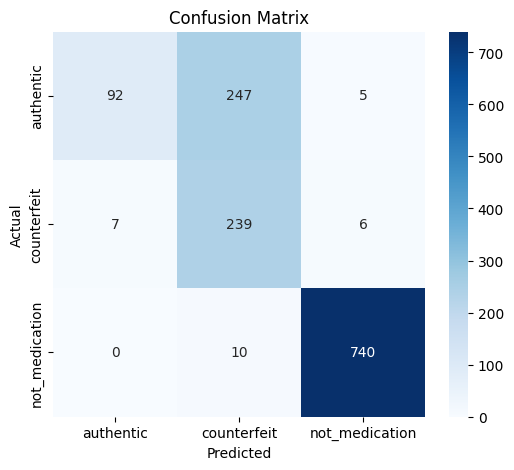

📋 Classification Report:
                precision    recall  f1-score   support

     authentic     0.9293    0.2674    0.4153       344
   counterfeit     0.4819    0.9484    0.6390       252
not_medication     0.9854    0.9867    0.9860       750

      accuracy                         0.7957      1346
     macro avg     0.7988    0.7342    0.6801      1346
  weighted avg     0.8768    0.7957    0.7752      1346



In [ ]:
evaluate_model_metrics(model, test_loader,class_names)

# Manually Testing on Unforseen Data not in Testing Set

In [ ]:

def predict_image(image_path, transform, model, class_names):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs, dim=1)  # Get class probabilities
        confidence, pred_class = torch.max(probs, 1)  # Top prediction

    return {
        "prediction": class_names[pred_class.item()],
        "confidence": float(confidence.item()),
        "probabilities": probs.cpu().numpy().flatten().tolist()
    }

# Testing to see if it can distinguish between a medication and non-med

In [ ]:
result = predict_image(
    "/content/drive/MyDrive/Colab_Notebooks/counterfeit_drug_super_dataset/person.jpg",
    val_test_transform,
    model,
    class_names
)

print("Prediction Result:", result)

Prediction Result: {'prediction': 'not_medication', 'confidence': 0.9999202489852905, 'probabilities': [2.809791658364702e-05, 5.158302519703284e-05, 0.9999202489852905]}


# Testing to see if it can distinguish a drug package as authentic

In [ ]:
result = predict_image(
    "/content/drive/MyDrive/Colab_Notebooks/counterfeit_drug_super_dataset/parcetamol_cover.png",
    val_test_transform,
    model,
    class_names
)

print("Prediction Result:", result)

Prediction Result: {'prediction': 'authentic', 'confidence': 0.9524765014648438, 'probabilities': [0.9524765014648438, 0.0439252108335495, 0.003598286770284176]}


# Testing to see if it can distinguish a pill drug as authentic

In [ ]:
result = predict_image(
    "/content/drive/MyDrive/Colab_Notebooks/counterfeit_drug_super_dataset/parcetamol_tab.webp",
    val_test_transform,
    model,
    class_names
)

print("Prediction Result:", result)

Prediction Result: {'prediction': 'not_medication', 'confidence': 1.0, 'probabilities': [4.653340823779217e-09, 2.4352878047473325e-10, 1.0]}


# Testing to see if it can detect a counterfeit drug

In [ ]:
result = predict_image(
    "/content/drive/MyDrive/Colab_Notebooks/counterfeit_drug_super_dataset/folic-acid_jpg_mock.jpg",
    val_test_transform,
    model,
    class_names
)

print("Prediction Result:", result)

Prediction Result: {'prediction': 'counterfeit', 'confidence': 0.9999713897705078, 'probabilities': [2.854610102076549e-05, 0.9999713897705078, 4.0201722839583454e-08]}


# Testing to see if it will predict the authentic image as authentic

In [ ]:
result = predict_image(
    "/content/drive/MyDrive/Colab_Notebooks/counterfeit_drug_super_dataset/folicacid_auth.jpg",
    val_test_transform,
    model,
    class_names
)

print("Prediction Result:", result)

Prediction Result: {'prediction': 'authentic', 'confidence': 0.8904287219047546, 'probabilities': [0.8904287219047546, 0.10951853543519974, 5.280220284475945e-05]}


# I will retrain using resnet50 in the next iteration to see if it may perform better we will go with the super dataset as it is great at convincing the model that these are authentics

In [ ]:
model = get_model("resnet50")  # ResNet50

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


In [ ]:
train_model(model, train_loader, val_loader, epochs=20, patience=3)

Epoch [1/20] - Loss: 0.1293 - Val Accuracy: 96.35%
Epoch [2/20] - Loss: 0.0667 - Val Accuracy: 97.77%
Epoch [3/20] - Loss: 0.0530 - Val Accuracy: 96.97%
Epoch [4/20] - Loss: 0.0561 - Val Accuracy: 98.40%
Epoch [5/20] - Loss: 0.0361 - Val Accuracy: 98.17%
Epoch [6/20] - Loss: 0.0375 - Val Accuracy: 97.60%
Epoch [7/20] - Loss: 0.0360 - Val Accuracy: 98.00%
Early stopping triggered at epoch 7


In [ ]:
test_acc = evaluate_model(model, test_loader)
print(f" Final Test Accuracy: {test_acc:.2f}%")

 Final Test Accuracy: 86.99%


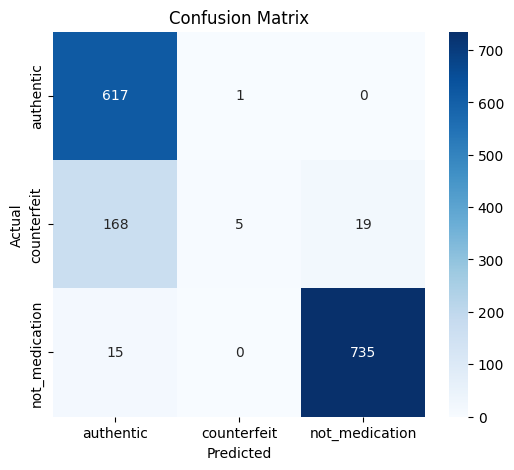

📋 Classification Report:
                precision    recall  f1-score   support

     authentic     0.7712    0.9984    0.8702       618
   counterfeit     0.8333    0.0260    0.0505       192
not_medication     0.9748    0.9800    0.9774       750

      accuracy                         0.8699      1560
     macro avg     0.8598    0.6681    0.6327      1560
  weighted avg     0.8768    0.8699    0.8209      1560



In [ ]:
evaluate_model_metrics(model, test_loader,class_names)

# Training with Resnet101

In [ ]:
model = get_model("resnet101")  # ResNet101

In [ ]:
train_model(model, train_loader, val_loader, epochs=20, patience=3)

Epoch [1/20] - Loss: 0.1562 - Val Accuracy: 84.87%
Epoch [2/20] - Loss: 0.0693 - Val Accuracy: 94.01%
Epoch [3/20] - Loss: 0.0482 - Val Accuracy: 97.09%
Epoch [4/20] - Loss: 0.0461 - Val Accuracy: 97.77%
Epoch [5/20] - Loss: 0.0398 - Val Accuracy: 98.52%
Epoch [6/20] - Loss: 0.0350 - Val Accuracy: 96.58%
Epoch [7/20] - Loss: 0.0350 - Val Accuracy: 96.00%
Epoch [8/20] - Loss: 0.0447 - Val Accuracy: 98.17%
Early stopping triggered at epoch 8


In [ ]:
test_acc = evaluate_model(model, test_loader)
print(f" Final Test Accuracy: {test_acc:.2f}%")

 Final Test Accuracy: 89.04%


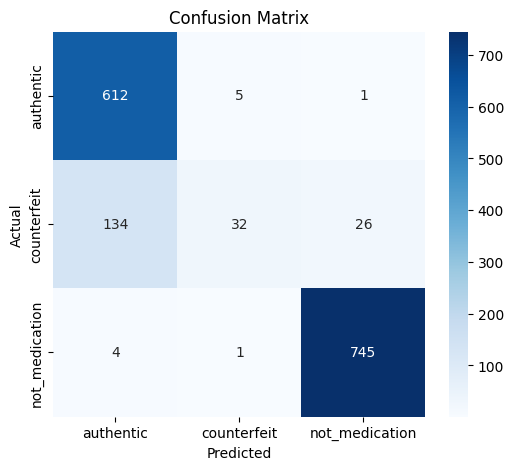

📋 Classification Report:
                precision    recall  f1-score   support

     authentic     0.8160    0.9903    0.8947       618
   counterfeit     0.8421    0.1667    0.2783       192
not_medication     0.9650    0.9933    0.9790       750

      accuracy                         0.8904      1560
     macro avg     0.8744    0.7168    0.7173      1560
  weighted avg     0.8909    0.8904    0.8594      1560



In [ ]:
evaluate_model_metrics(model, test_loader,class_names)

# Will go with first Iteration, and dataset. Training again on the first dataset using resnet50

In [10]:
# Paths
train_path = "/content/drive/MyDrive/Colab_Notebooks/Counterfeit_med_dataset_trainOnGenAI_testOnGenAI&Albu/train"
val_path = "/content/drive/MyDrive/Colab_Notebooks/Counterfeit_med_dataset_trainOnGenAI_testOnGenAI&Albu/valid"
test_path = "/content/drive/MyDrive/Colab_Notebooks/Counterfeit_med_dataset_trainOnGenAI_testOnGenAI&Albu/test"


# Datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=val_test_transform)

# Class distribution insight
print("Class distribution in training set:")
print(Counter([label for _, label in train_dataset]))

class_names = train_dataset.classes  # ['authentic', 'counterfeit', 'not_medication']



train_loader = DataLoader(train_dataset, batch_size=128,num_workers=4, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=4, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128,num_workers=4, pin_memory=True, shuffle=False)


Class distribution in training set:
Counter({2: 3500, 0: 2886, 1: 762})


In [11]:
model = get_model("resnet50")  # ResNet50

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 45.9MB/s]


In [13]:
train_model(model, train_loader, val_loader, epochs=20, patience=3)

Epoch [1/20] - Loss: 0.2342 - Val Accuracy: 89.84%
Epoch [2/20] - Loss: 0.0802 - Val Accuracy: 86.76%
Epoch [3/20] - Loss: 0.0677 - Val Accuracy: 90.13%
Epoch [4/20] - Loss: 0.0518 - Val Accuracy: 95.72%
Epoch [5/20] - Loss: 0.0395 - Val Accuracy: 91.61%
Epoch [6/20] - Loss: 0.0416 - Val Accuracy: 90.81%
Epoch [7/20] - Loss: 0.0351 - Val Accuracy: 94.35%
Early stopping triggered at epoch 7


In [ ]:
test_acc = evaluate_model(model, test_loader)
print(f" Final Test Accuracy: {test_acc:.2f}%")

 Final Test Accuracy: 96.22%


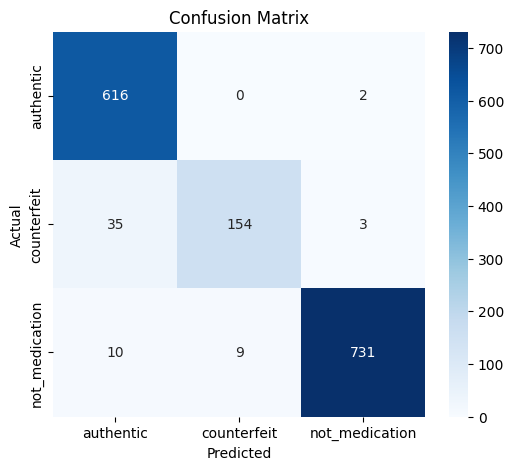

📋 Classification Report:
                precision    recall  f1-score   support

     authentic     0.9319    0.9968    0.9633       618
   counterfeit     0.9448    0.8021    0.8676       192
not_medication     0.9932    0.9747    0.9838       750

      accuracy                         0.9622      1560
     macro avg     0.9566    0.9245    0.9382      1560
  weighted avg     0.9630    0.9622    0.9614      1560



In [ ]:
evaluate_model_metrics(model, test_loader,class_names)

## Testing with ResNet101

In [ ]:
model = get_model("resnet101")  # ResNet50

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_model(model, train_loader, val_loader, epochs=20, patience=3)

Epoch [1/20] - Loss: 0.2246 - Val Accuracy: 83.85%
Epoch [2/20] - Loss: 0.0956 - Val Accuracy: 94.75%
Epoch [3/20] - Loss: 0.0697 - Val Accuracy: 94.46%
Epoch [4/20] - Loss: 0.0486 - Val Accuracy: 83.16%
Epoch [5/20] - Loss: 0.0472 - Val Accuracy: 92.69%
Early stopping triggered at epoch 5


In [ ]:
test_acc = evaluate_model(model, test_loader)
print(f" Final Test Accuracy: {test_acc:.2f}%")

 Final Test Accuracy: 93.27%


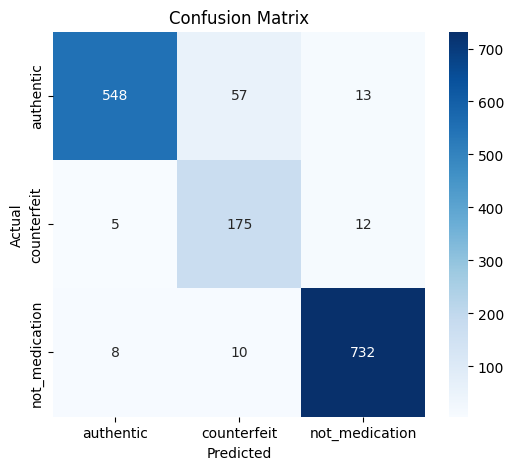

📋 Classification Report:
                precision    recall  f1-score   support

     authentic     0.9768    0.8867    0.9296       618
   counterfeit     0.7231    0.9115    0.8065       192
not_medication     0.9670    0.9760    0.9715       750

      accuracy                         0.9327      1560
     macro avg     0.8890    0.9247    0.9025      1560
  weighted avg     0.9409    0.9327    0.9346      1560



In [ ]:
evaluate_model_metrics(model, test_loader,class_names)

# Saving Model and going with ResNet 101

In [1]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/counterfeit_detector_v1.pt")

NameError: name 'torch' is not defined

In [ ]:
pip install fastapi uvicorn torch torchvision pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [ ]:
## Creating API Endpoint for Deployment

In [ ]:
from fastapi import FastAPI, File, UploadFile
from PIL import Image
import torch
import torchvision.transforms as transforms
import io

# Define the FastAPI app instance
app = FastAPI()

In [ ]:
# Load your trained model once when the app starts
model = torch.load("model_resnet101.pt")
model.eval()

In [ ]:
@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    image_bytes = await file.read()
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, dim=1)

    class_map = {0: "authentic", 1: "counterfeit", 2: "not_medication"}
    predicted_label = class_map[predicted_class.item()]
    confidence_score = round(confidence.item(), 4)

    return {
        "prediction": predicted_label,
        "confidence": confidence_score,
        "message": f"This image is most likely '{predicted_label}' with a confidence of {confidence_score:.2%}"
    }

In [ ]:
pip freeze > requirements.txt